<a href="https://colab.research.google.com/github/yohanesnuwara/66DaysOfData/blob/main/D05_data_leakage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data leakage

A problem in ML. Data leakage makes model to be overly optimistic. 

Causes of data leakage:

* Leaky predictors
* Incorrect data preparation (train-test split)
* Not cross-validated or incorrect cross-validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

## Leakage because of predictor

Consider this:

![image](https://user-images.githubusercontent.com/51282928/124861505-e9e81680-dfdd-11eb-9266-84bf90a31300.png)

We will use credit card data.

In [2]:
path = 'https://raw.githubusercontent.com/yohanesnuwara/datasets/master/AER_credit_card_data.csv'

data = pd.read_csv(path, true_values=['yes'], false_values=['no'])
data

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,True,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,True,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,True,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,True,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,True,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,True,0,33.58333,4.5660,0.002146,7.333333,True,False,0,94,1,19
1315,False,5,23.91667,3.1920,0.000376,0.000000,False,False,3,12,1,5
1316,True,0,40.58333,4.6000,0.026513,101.298300,True,False,2,1,1,2
1317,True,0,32.83333,3.7000,0.008999,26.996670,False,True,0,60,1,7


Then we fit with model. It results 98% accuracy.

In [3]:
# Predictor and target
y = data.card
X = data.drop(['card'], axis=1)

# Since there was no preprocessing, we didn't need a pipeline here. Used anyway as best practice
modeling_pipeline = make_pipeline(RandomForestClassifier())
cv_scores = cross_val_score(modeling_pipeline, X, y, scoring='accuracy')
print("Cross-val accuracy: %f" %cv_scores.mean())

Cross-val accuracy: 0.980294


This very high accuracy is a bit non sense. We can detect some leaky predictors. 

We suspect "expenditure" predictor, because "expenditure" is AT THE SAME TIME with credit card application, NOT BEFORE. Another one is "share". More explanation is [here](https://www.kaggle.com/dansbecker/data-leakage) 

So, we eliminate those leaky predictors. 

In [4]:
# Eliminating leaky predictors
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
data2 = data.drop(potential_leaks, axis=1)

# Predictor and target
y = data2.card
X = data2.drop(['card'], axis=1)

cv_scores = cross_val_score(modeling_pipeline, X, y, scoring='accuracy')

print("Cross-val accuracy: %f" %cv_scores.mean())

Cross-val accuracy: 0.833204


In [5]:
# # Eliminating leaky predictors
# potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
# X2 = X.drop(potential_leaks, axis=1)
# cv_scores = cross_val_score(modeling_pipeline, X2, y, scoring='accuracy')

# print("Cross-val accuracy: %f" %cv_scores.mean())

Although smaller, 83% accuracy is more trusted, because we have eliminated leakage, so model is not biased. 

## Leakage caused by incorrect data preparation

Usually data preparation is done this order:
1. Impute and normalize
2. Train test split

1 then 2, which is incorrect, causing leakage. Correct one is 2 then 1.

See Josh Starmer's StatQuest video [here](https://www.youtube.com/watch?v=pSWRT9pObX0)

Simulate missing data.

In [6]:
def simulate_missing_data(df, number_of_nans):
  df2 = df.copy()
  column = df2.columns
  seeds = np.arange(len(column)) + 5

  for i in range(len(column)):
    np.random.seed(seeds[i])
    rand_nan_id = np.random.randint(len(df), size=number_of_nans)
    for j in range(len(rand_nan_id)):
      df2[column[i]].iloc[rand_nan_id[j],:] = np.nan  
  return df2

In [7]:
# Create synthetic missing data at random index
data3 = simulate_missing_data(data2, 100)

data3.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,card,reports,age,income,owner,selfemp,dependents,months
0,1.0,0.0,37.66667,4.5200,1.0,0.0,3.0,54.0
1,1.0,0.0,33.25000,2.4200,NaN,0.0,NaN,34.0
2,1.0,0.0,33.66667,4.5000,1.0,0.0,4.0,58.0
3,1.0,0.0,30.50000,2.5400,0.0,0.0,0.0,25.0
4,1.0,0.0,32.16667,9.7867,1.0,NaN,2.0,64.0


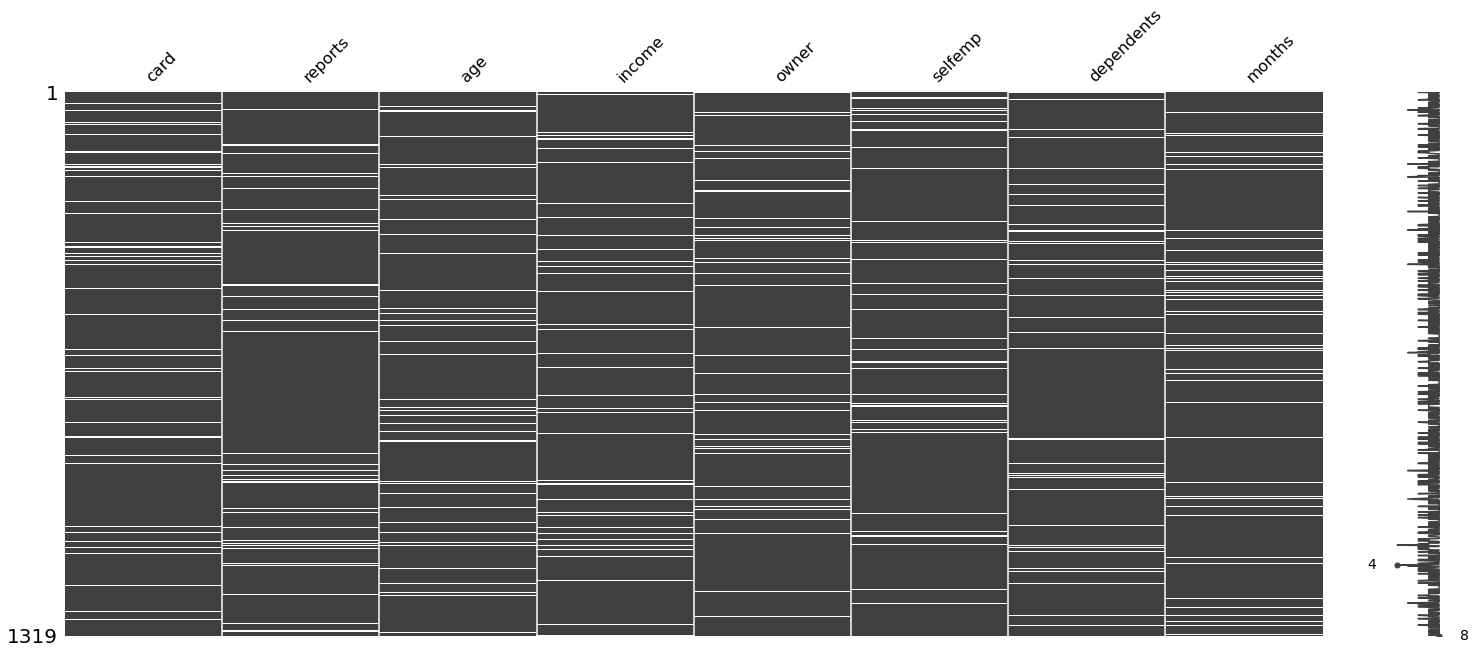

In [8]:
import missingno as msno

msno.matrix(data3)

Using incorrect workflow 1 then 2. Accuracy is 80.9%. 

In [9]:
# drop NaN data in card (target) column
data3 = data3.dropna(subset=['card'])

y = data3.card
X = data3.drop(['card'], axis=1)

# imputing
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)

# standardize the dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy*100))

Accuracy: 80.941


Using the correct workflow 2 then 1. Accuracy is 81.6%.

In [10]:
# drop NaN data in card (target) column
data3 = data3.dropna(subset=['card'])

y = data3.card
X = data3.drop(['card'], axis=1)

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# impute
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)

X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# define the scaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# evaluate the model
yhat = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy*100))

Accuracy: 81.683


Accuracy without leakage is slightly better than accuracy with leakage. Performance has increased slightly. 

## Leakage caused by incorrect cross-validation

We used to do CV without using pipeline. This can cause leakage. Accuracy is 81.5%

In [11]:
# drop NaN data in card (target) column
data3 = data3.dropna(subset=['card'])

y = data3.card
X = data3.drop(['card'], axis=1)

# imputing
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)

# standardize the dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model using cross-validation
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))

Accuracy: 81.178 (2.106)


We use Pipeline to avoid leakage. Accuracy is 81.2%

In [12]:
# drop NaN data in card (target) column
data3 = data3.dropna(subset=['card'])

y = data3.card
X = data3.drop(['card'], axis=1)

# define the pipeline
steps = list()
steps.append(('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')))
steps.append(('scaler', MinMaxScaler()))
steps.append(('model', RandomForestClassifier()))
pipeline = Pipeline(steps=steps)

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))

Accuracy: 81.315 (2.080)


Both accuracies are very close. But we already know that Pipelining reduces chance of leakage.

References:
* https://www.kaggle.com/dansbecker/data-leakage
* https://machinelearningmastery.com/data-preparation-without-data-leakage/
* https://towardsdatascience.com/pre-process-data-with-pipeline-to-prevent-data-leakage-during-cross-validation-e3442cca7fdc
* Other resources:
  * Josh Starmer's StatQuest video [here](https://www.youtube.com/watch?v=pSWRT9pObX0) 
  * Explanation on data leakage from University of Michigan: https://python-data-science.readthedocs.io/en/latest/dataleakage.html
  * https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/